In [71]:
!pip install fuzzy-c-means

In [72]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import os
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from itertools import chain
from fcmeans import FCM

In [73]:
#Get vocabulary & counts for hashtag appearances
#hashtag_counts: a dictionary with key: a hashtag, value: count of that hashtag in the file

my_dir = './data'
for item in os.listdir(my_dir):
    filepath = os.path.join(my_dir, item)
    if os.path.isfile(filepath) and 'merged' in filepath:
        print(filepath)
        df = pd.read_csv(os.path.join(my_dir, item))
        df['Hashtags'] = df['Text'].apply(lambda x: re.findall(r"#(\w+)", x))
        
        #ignore case of hashtags
        df['Hashtags_lower']=df['Hashtags'].apply(lambda x: [y.lower() for y in x])
        
        #Remove tweets that do not contain #capitolriots
        to_drop=[]
        for i,row in df.iterrows():
            if 'capitolriots' not in row['Hashtags_lower']:
                to_drop.append(i)
        df.drop(to_drop, axis=0, inplace=True)
        
        #ignore duplicate hashtags
        df['Hashtags_lower_uniques']=df['Hashtags_lower'].apply(lambda x: list(set(x)))
        
        tweet_hashtags = chain.from_iterable(df['Hashtags_lower_uniques'].tolist())

print(len(df.index))

./data/scraped_tweets_merged
126870


In [74]:
#Create bag of words

bow_converter = CountVectorizer(tokenizer=lambda doc: doc, binary=True, min_df=5, lowercase=False)
bow = bow_converter.fit_transform(df['Hashtags_lower_uniques'])

vocabulary = bow_converter.get_feature_names()
print(len(vocabulary))

4539


In [75]:
#Average number of hashtags in each tweet
print(bow.nnz/bow.shape[0])

3.1387483250571453


In [76]:
#Commented out because was taking way too long to run

# #Fuzzy C-means Clustering

# bow_arr = bow.toarray()

# true_k=3
# fcm = FCM(n_clusters=true_k)
# fcm.fit(bow_arr)
# predictions = fcm.predict(bow_arr)

In [77]:
# #Number of tweets in each cluster
# cluster_counts=[0 for _ in range(true_k)]
# for asn in predictions:
#     cluster_counts[asn]+=1
# print(cluster_counts)

In [78]:
#Reduce bag of words to 2 dimensions
svd = TruncatedSVD(n_components=2, n_iter=10)
bow_svd=svd.fit_transform(bow)

Text(0.5, 1.0, 'All data')

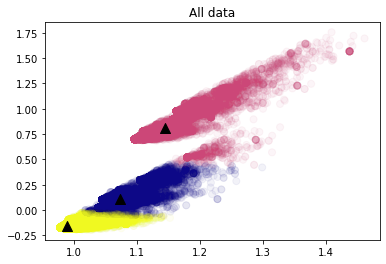

In [79]:
#Run fuzzy clustering on the lower-dimension bow


#Choose k=3 because when running fuzzy clustering on the non-dimensionality-reduced bow, 
#the optimal number of clusters was 3. For k>3, some of the clusters contained 0 hashtags.
k_svd=3
fcm_svd = FCM(n_clusters=k_svd)
fcm_svd.fit(bow_svd)
predictions_svd = fcm_svd.predict(bow_svd)

plt.scatter(bow_svd[:, 0], bow_svd[:, 1], c=predictions_svd, s=50, cmap='plasma', alpha=0.05)

centers = fcm_svd.centers
plt.scatter(centers[:, 0], centers[:, 1], c='k', marker='^', s=100)
plt.title('All data')

In [80]:
my_dir = './data'
df = pd.read_csv('./data/scraped_tweets_tf1')
df['Hashtags'] = df['Text'].apply(lambda x: re.findall(r"#(\w+)", x))

#ignore case of hashtags
df['Hashtags_lower']=df['Hashtags'].apply(lambda x: [y.lower() for y in x])

#Remove tweets that do not contain #capitolriots
to_drop=[]
for i,row in df.iterrows():
    if 'capitolriots' not in row['Hashtags_lower']:
        to_drop.append(i)
df.drop(to_drop, axis=0, inplace=True)

#ignore duplicate hashtags
df['Hashtags_lower_uniques']=df['Hashtags_lower'].apply(lambda x: list(set(x)))

tweet_hashtags = chain.from_iterable(df['Hashtags_lower_uniques'].tolist())

print(len(df.index))

62025


In [81]:
#Create bag of words

bow_converter = CountVectorizer(tokenizer=lambda doc: doc, binary=True, min_df=5, lowercase=False)
bow = bow_converter.fit_transform(df['Hashtags_lower_uniques'])

vocabulary = bow_converter.get_feature_names()
print(len(vocabulary))

2378


In [82]:
#Reduce bag of words to 2 dimensions
svd = TruncatedSVD(n_components=2, n_iter=10)
bow_svd=svd.fit_transform(bow)

Text(0.5, 1.0, 'Timeframe 1')

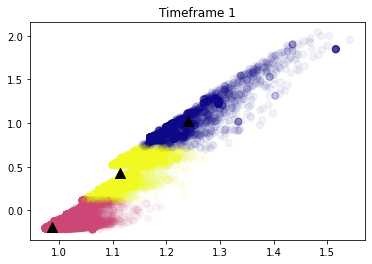

In [83]:
#Run fuzzy clustering on the lower-dimension bow

k_svd=3
fcm_svd = FCM(n_clusters=k_svd)
fcm_svd.fit(bow_svd)
predictions_svd = fcm_svd.predict(bow_svd)

plt.scatter(bow_svd[:, 0], bow_svd[:, 1], c=predictions_svd, s=50, cmap='plasma', alpha=0.05)

centers = fcm_svd.centers
plt.scatter(centers[:, 0], centers[:, 1], c='k', marker='^', s=100)
plt.title('Timeframe 1')

In [84]:
my_dir = './data'
df = pd.read_csv('./data/scraped_tweets_tf2')
df['Hashtags'] = df['Text'].apply(lambda x: re.findall(r"#(\w+)", x))

#ignore case of hashtags
df['Hashtags_lower']=df['Hashtags'].apply(lambda x: [y.lower() for y in x])

#Remove tweets that do not contain #capitolriots
to_drop=[]
for i,row in df.iterrows():
    if 'capitolriots' not in row['Hashtags_lower']:
        to_drop.append(i)
df.drop(to_drop, axis=0, inplace=True)

#ignore duplicate hashtags
df['Hashtags_lower_uniques']=df['Hashtags_lower'].apply(lambda x: list(set(x)))

tweet_hashtags = chain.from_iterable(df['Hashtags_lower_uniques'].tolist())

print(len(df.index))

46600


In [85]:
#Create bag of words

bow_converter = CountVectorizer(tokenizer=lambda doc: doc, binary=True, min_df=5, lowercase=False)
bow = bow_converter.fit_transform(df['Hashtags_lower_uniques'])

vocabulary = bow_converter.get_feature_names()
print(len(vocabulary))

2185


In [86]:
#Reduce bag of words to 2 dimensions
svd = TruncatedSVD(n_components=2, n_iter=10)
bow_svd=svd.fit_transform(bow)

Text(0.5, 1.0, 'Timeframe 2')

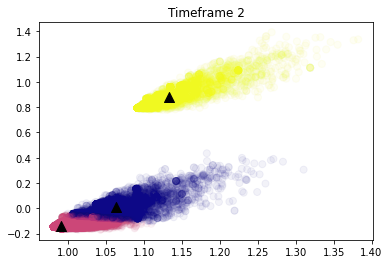

In [87]:
#Run fuzzy clustering on the lower-dimension bow

k_svd=3
fcm_svd = FCM(n_clusters=k_svd)
fcm_svd.fit(bow_svd)
predictions_svd = fcm_svd.predict(bow_svd)

plt.scatter(bow_svd[:, 0], bow_svd[:, 1], c=predictions_svd, s=50, cmap='plasma', alpha=0.05)

centers = fcm_svd.centers
plt.scatter(centers[:, 0], centers[:, 1], c='k', marker='^', s=100)
plt.title('Timeframe 2')

In [88]:
my_dir = './data'
df = pd.read_csv('./data/scraped_tweets_tf3')
df['Hashtags'] = df['Text'].apply(lambda x: re.findall(r"#(\w+)", x))

#ignore case of hashtags
df['Hashtags_lower']=df['Hashtags'].apply(lambda x: [y.lower() for y in x])

#Remove tweets that do not contain #capitolriots
to_drop=[]
for i,row in df.iterrows():
    if 'capitolriots' not in row['Hashtags_lower']:
        to_drop.append(i)
df.drop(to_drop, axis=0, inplace=True)

#ignore duplicate hashtags
df['Hashtags_lower_uniques']=df['Hashtags_lower'].apply(lambda x: list(set(x)))

tweet_hashtags = chain.from_iterable(df['Hashtags_lower_uniques'].tolist())

print(len(df.index))

18245


In [89]:
#Create bag of words

bow_converter = CountVectorizer(tokenizer=lambda doc: doc, binary=True, min_df=5, lowercase=False)
bow = bow_converter.fit_transform(df['Hashtags_lower_uniques'])

vocabulary = bow_converter.get_feature_names()
print(len(vocabulary))

1106


In [90]:
#Reduce bag of words to 2 dimensions
svd = TruncatedSVD(n_components=2, n_iter=10)
bow_svd=svd.fit_transform(bow)

Text(0.5, 1.0, 'Timeframe 3')

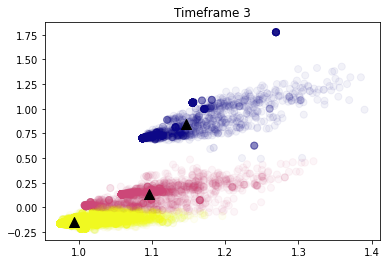

In [91]:
#Run fuzzy clustering on the lower-dimension bow

k_svd=3
fcm_svd = FCM(n_clusters=k_svd)
fcm_svd.fit(bow_svd)
predictions_svd = fcm_svd.predict(bow_svd)

plt.scatter(bow_svd[:, 0], bow_svd[:, 1], c=predictions_svd, s=50, cmap='plasma', alpha=0.05)

centers = fcm_svd.centers
plt.scatter(centers[:, 0], centers[:, 1], c='k', marker='^', s=100)
plt.title('Timeframe 3')